## Introduction: 
In This kernel I will be solving House Pricing with Advanced Regression Analysis.

## What we want?
1. Gathering Data
2. Analysis the target and understand what is the important features
3. Looking for missing values
4. Feature Engineering
5. Converting categorical to numerical
6. Modeling

In [11]:
## Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math
from scipy.stats import norm, skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pylab as pylab

In [12]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'legend.title_fontsize':'x-large'}
pylab.rcParams.update(params)

## 1. Gathering Data

In [5]:
train = pd.read_csv('houseprice_train.csv')
test = pd.read_csv('houseprice_test.csv')



In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
train.shape , test.shape 

((1460, 81), (1459, 80))

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Obviously we have some features that have many missing valuesز we'll deal with it in a little while.


### 2. Let's know more about the Target and make some analysis
You may wonder what the target is? 
It's the 'SalePrice' column. 

In [9]:
print(train['SalePrice'].describe())



count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


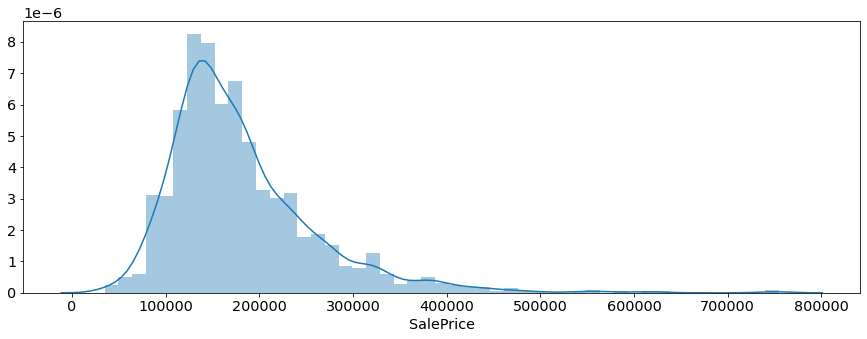

In [13]:
 sns.distplot(train['SalePrice'])


As we see, we have a positive sekew, we must fix it.

In [14]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())


Skewness: 1.882876
Kurtosis: 6.536282


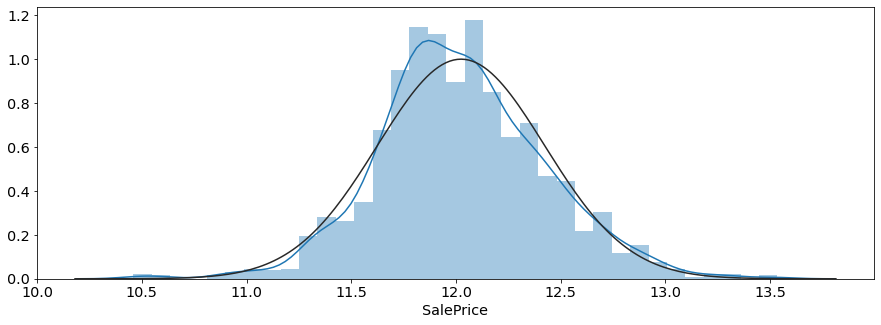

In [15]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm);



Now we fixed it.

### Are we need a specialist or a broker to know what are the most important features that affect home prices?
Of course not, we can know the important features by sea. So let's go and explore the data.


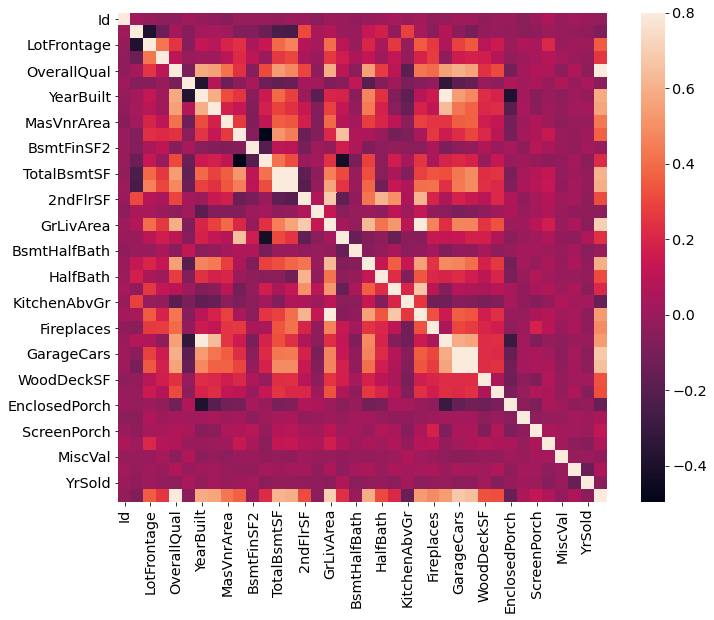

In [17]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


Ok, now as you see the correlation between features.. The colours show to us the strong and weak correlation.
But what we really need? we need the highest correlation between features and SalesPrice, so let's do it.

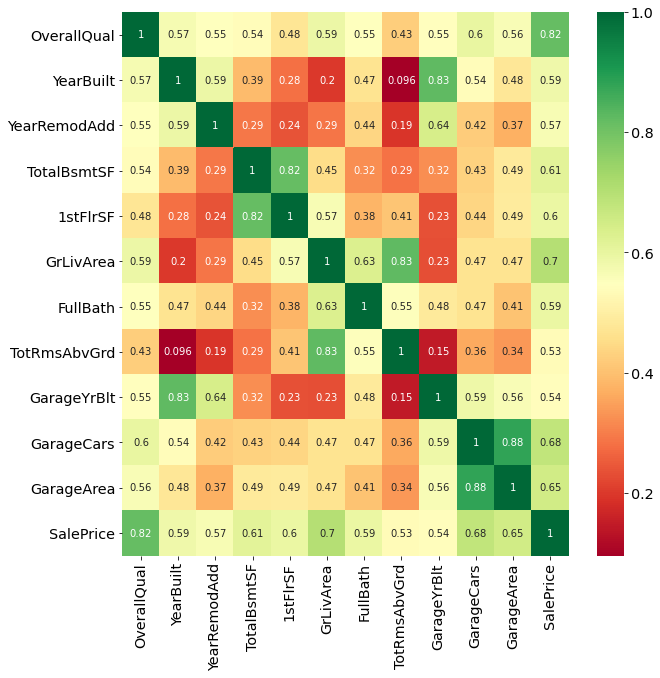

In [18]:
corr = train.corr()
highest_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[highest_corr_features].corr(),annot=True,cmap="RdYlGn")


#### What we note?
* It's important to know what you do and how benefit from it. We can see 'OverQual' in the top of highest correlation it's 0.79!
* 'GarageCars' & 'GarageArea' like each other (correlation between them is 0.88) 
* 'TotalBsmtSF' & '1stFlrSF' also like each other (correlation betwwen them is 0.82), so we can keep either one of them or add the1stFlrSF to the Toltal.
* 'TotRmsAbvGrd' & 'GrLivArea' also has a strong correlation (0.83), I decided to keep 'GrLivArea' because it's correlation with 'SalePrice' is higher.


In [19]:
corr["SalePrice"].sort_values(ascending=False)


SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

#### ok let's focus on the features have highest correlation.

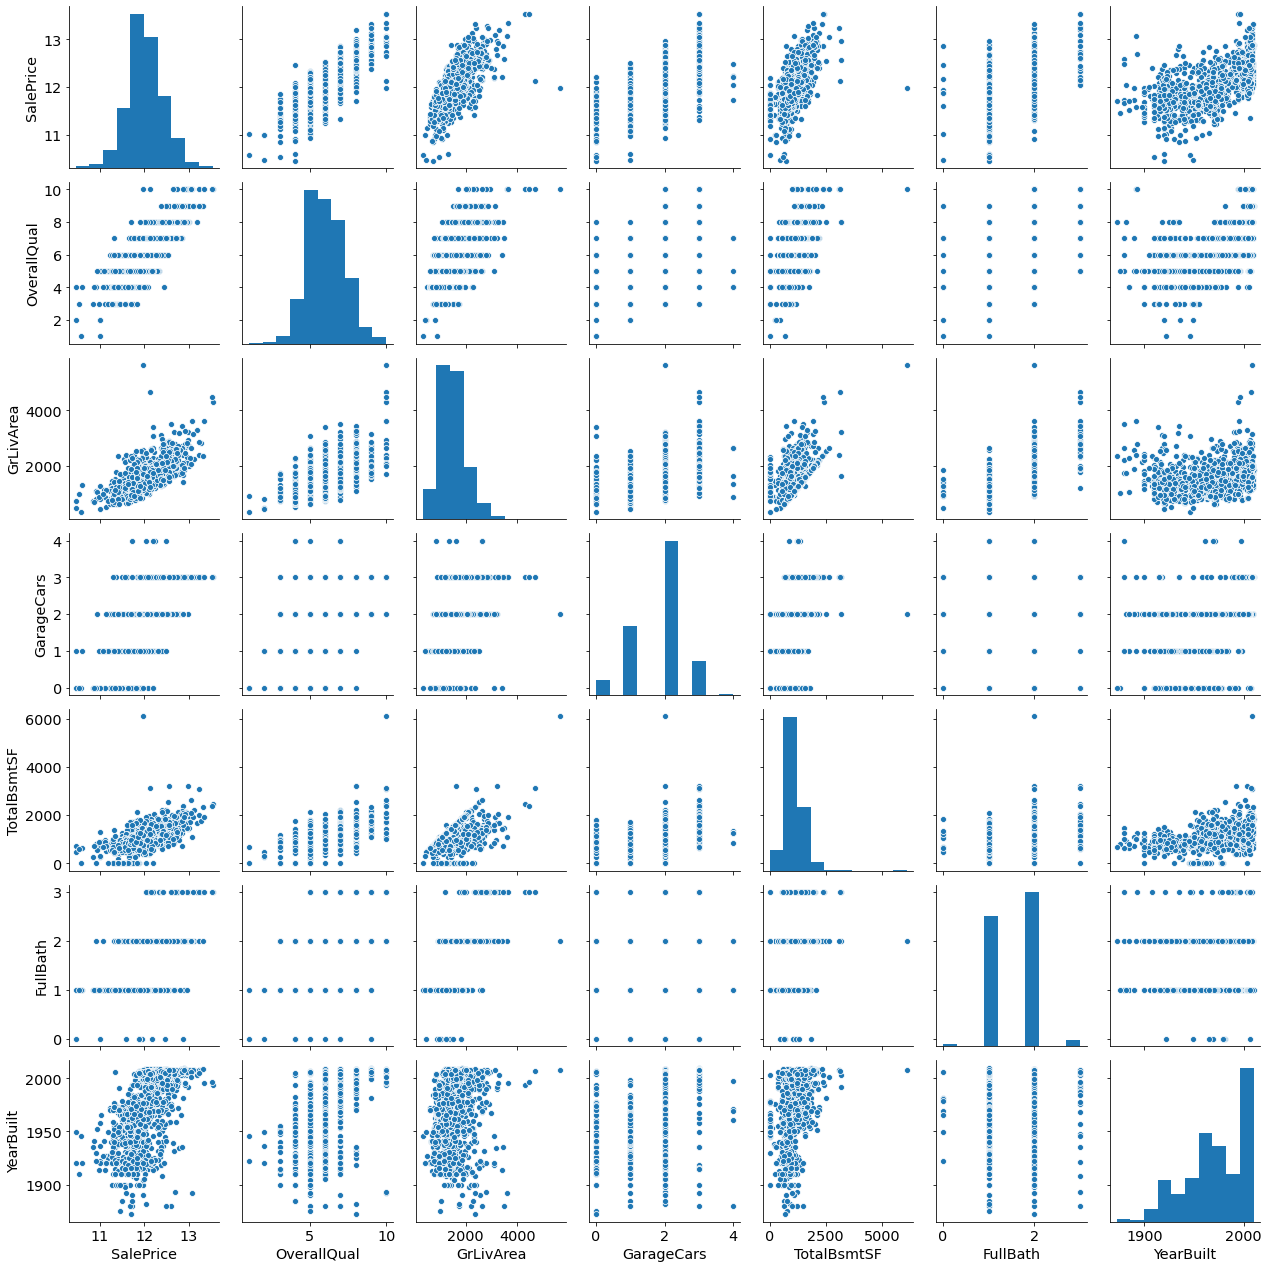

In [20]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])


Now, We explored the data and know the important features.

## 2. Looking for Missing Data 

#### Before looking for Missing data: 
We can concatenate train and test datasets, preprocess, and then divide them again. I think it will be easy for us.

In [21]:
y_train = train['SalePrice']
test_id = test['Id']
all_data = pd.concat([train, test], axis=0, sort=False)
all_data = all_data.drop(['Id', 'SalePrice'], axis=1)


In [24]:
Total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)


,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


Well, if we look at these features that have many missing values, we will note that they are not important features, none of them has (correlation > 0.5), so if we delete them we will not miss the data.

In [25]:
all_data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
print(all_data.isnull().sum().max())


4


Let's show the features and the number of Missing values

In [26]:
total = all_data.isnull().sum().sort_values(ascending=False)
total.head(19)

MSZoning        4
BsmtHalfBath    2
BsmtFullBath    2
Functional      2
Utilities       2
Exterior1st     1
KitchenQual     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
Exterior2nd     1
SaleType        1
TotalBsmtSF     1
BsmtUnfSF       1
BsmtFinSF2      1
Electrical      1
YearBuilt       0
ExterQual       0
RoofMatl        0
dtype: int64

### Now, Filling the missing Data

In [27]:
# filling the numeric data
numeric_missed = ['BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath',
                  'GarageArea',
                  'GarageCars']

for feature in numeric_missed:
    all_data[feature] = all_data[feature].fillna(0)


In [28]:
#filling categorical data
categorical_missed = ['Exterior1st',
                  'Exterior2nd',
                  'SaleType',
                  'MSZoning',
                   'Electrical',
                     'KitchenQual']

for feature in categorical_missed:
    all_data[feature] = all_data[feature].fillna(all_data[feature].mode()[0])


In [29]:
#Fill in the remaining missing values with the values that are most common for this feature.

all_data['Functional'] = all_data['Functional'].fillna('Typ')


In [30]:
all_data.drop(['Utilities'], axis=1, inplace=True)


let's check if we have another missing values.

In [31]:
all_data.isnull().sum().max() #just checking that there's no missing data missing...


0

## 4. Feature Engineering

#### Fix The Skewness in the other features


In [23]:

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [24]:
for feature in high_skew.index:
    all_data[feature] = np.log1p(all_data[feature])


#### Let's add a new features

In [25]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']



## 5. Converting the categorical to numerical.

In [26]:
all_data = pd.get_dummies(all_data)
all_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,...,0,0,0,1,0,0,0,0,1,0


#### We cleaned the data very well, and now let's separate the data to its origin (train, test)

In [27]:
x_train =all_data[:len(y_train)]
x_test = all_data[len(y_train):]


In [28]:
x_test.shape , x_train.shape

((1459, 219), (1460, 219))

## 5. Apply ML Model

In [29]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(x_train.values)
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, x_test, y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)


In [30]:
import xgboost as XGB

the_model = XGB.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
the_model.fit(x_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, subsample=0.5213, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
y_predict = np.floor(np.expm1(the_model.predict(x_test)))
y_predict


array([125978., 162983., 185833., ..., 170827., 121675., 221901.],
      dtype=float32)

In [32]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = y_predict
sub.to_csv('mysubmission.csv',index=False)